Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


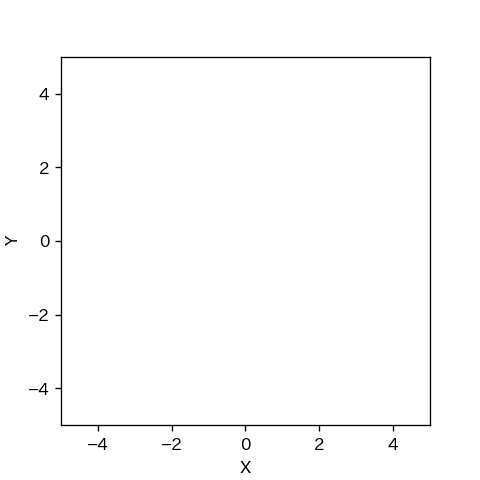

In [1]:
import sys
sys.path.append("../scripts/")
import matplotlib.animation as anm
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_kidnap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
#  phantom_prob=0.1
    world.draw()
    #world.ani.save()
    return(r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


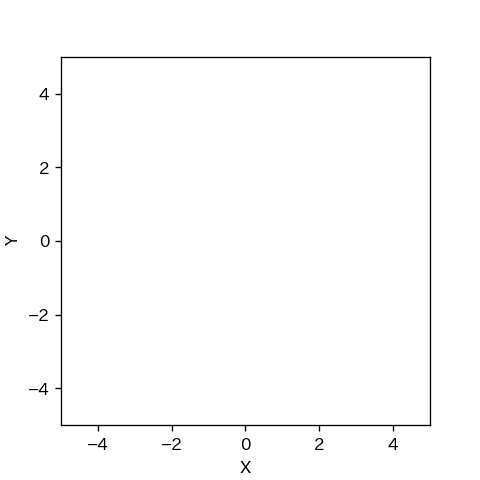

(array([-4.76293639, -2.35937943, -1.91375283]),
 array([-4.46250534, -2.58073344,  2.73381943]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

[5.959300264922786, 6.154036945488971]
0 真値: [-3.21081032  1.09957321  5.24880301] 推定値: [-3.24251263  1.08759991  5.12062446] 誤差: 0.03388799462460973
1
[6.20472196448512]
1 真値: [-0.03361483 -2.45395097  4.92483268] 推定値: [ 0.36662709 -2.13896393  5.78146712] 誤差: 0.509323499950102
2
[1.4599218505192386]
2 真値: [3.17890003 0.81051911 5.81216004] 推定値: [3.23230753 0.52839159 5.63481258] 誤差: 0.28713812406525924
3
[5.666185731131315]
3 真値: [-0.03408381 -2.91944517  6.70047549] 推定値: [-0.32695679 -2.73109698  6.65752907] 誤差: 0.3482091670169944
4
[7.158170888133748]
4 真値: [-3.32075429 -4.83016248  7.61884991] 推定値: [ 7.53133672 -2.39715861 -2.05997164] 誤差: 11.121483138573181
[6.635146832377486]
5 真値: [-2.06376298 -2.96622848  5.54297836] 推定値: [-1.76539191 -2.89540156  5.5417915 ] 誤差: 0.30666226576447186
5
[1.7111648085716942]
6 真値: [ 5.02052427 -2.88035308  8.54917598] 推定値: [ 4.46765547 -5.2235078   7.80012725] 誤差: 2.4074961986850454
[1.7910638974536421]
7 真値: [-0.35500151 -1.00963475  4.2300104 ]

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[1.9448549247286138]
20 真値: [ 1.07733033 -2.64316531  8.81492307] 推定値: [ 2.71196572 -2.24247338  0.57780757] 誤差: 1.6830290797204934
[2.823826196489495]
21 真値: [-0.36233111  2.77465969  2.72042969] 推定値: [0.0864418  2.58373484 2.58609912] 誤差: 0.48769809236386796
14
[5.147448994658904]
22 真値: [-3.42462538 -3.4289612   4.15990215] 推定値: [-3.27904087 -3.40087996  3.7770102 ] 誤差: 0.14826802365957212
15
[2.680675080826737]
[4.964301265030826, 1.5713968702312704]
23 真値: [3.66788761 1.79987051 3.79161527] 推定値: [3.83369672 1.91720062 3.653585  ] 誤差: 0.2031231543341433
16
[5.599834105730199]
24 真値: [ 1.07937827 -3.23878373  4.769914  ] 推定値: [ 7.84284321 -0.1620243   7.20772911] 誤差: 7.4304041928584095
[6.138677204963923]
25 真値: [-1.94277617  2.98081571  3.34772754] 推定値: [-2.11386526  3.84894624  3.59558653] 誤差: 0.8848288585263469
17
[1.044213046875871]
26 真値: [4.508235   2.96545095 8.58676255] 推定値: [4.34980247 2.57552962 8.31006179] 誤差: 0.42087944574104086
18
[2.0415129996975567]
27 真値: [ 0.1949045